In [1]:
from qiskit import QuantumCircuit
import numpy as np 
import scipy
import pandas as pd
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit import Aer
import post_processing as pp
import qutip as qtp
import random as random
import hamiltonian_class_package as hcp 
from tqdm.notebook import tqdm
import pickle
import os

identity = np.array([(1,0),(0,1)],dtype=np.complex128)
sigma_x = np.array([(0,1),(1,0)],dtype=np.complex128)
sigma_y = np.array([(0,-1j),(1j,0)],dtype=np.complex128)
sigma_z = np.array([(1,0),(0,-1)],dtype=np.complex128)
sigmas = [identity, sigma_x, sigma_y,sigma_z]

In [2]:
def isToPs(index_string):
    '''
    converts an index string like "123" to the corresponding pauli string: sx otimes sy otimes sz
    '''
    first_matrix = sigmas[int(index_string[0])]
    matrix = first_matrix
    for j in index_string[1:]:
        matrix = np.kron(matrix, sigmas[int(j)])
    return matrix

def total_sz_opr(numQubits):
    op = isToPs("3" + "0"*(numQubits-1))
    for i in range(1,numQubits):
        indexStr = "0"*i +"3" + "0"*(numQubits-i-1)
        # print(indexStr)
        op += isToPs(indexStr)
    return op


# def generate_two_qubit_N_operator(theta):
#     hermitian_op = np.kron(sigma_x,sigma_x)
#     hermitian_op += np.kron(sigma_y,sigma_y)
#     hermitian_op += np.kron(sigma_z,sigma_z)
#     hermitian_op *= 1j*theta
#     unitary_mat = scipy.linalg.expm(hermitian_op)
#     op = qi.Operator(unitary_mat)
#     return op

def generate_two_qubit_N_operator(theta):
    '''
    somehow this is diff from the commented out one above lol ohwell

    this is from Abol's paper
    '''
    qc = QuantumCircuit(2, name = "N({theta})".format(theta = theta))
    qc.rz(np.pi/2,1)
    qc.cx(1,0)
    qc.rz(2*theta - np.pi/2, 0)
    qc.ry(np.pi/2 - 2*theta, 1)
    qc.cx(0,1)
    qc.ry(2*theta - np.pi/2, 1)
    qc.cx(1,0)
    qc.rz(-np.pi/2,0)

    return qi.Operator(qc)

def create_combined_N_circuit(numQubits,params):
    '''
    numQubits must be an even integer
    '''
    N_gates_params = params[:numQubits-1]
    phase_gate_params = params[numQubits-1:]
    qc = QuantumCircuit(numQubits)
    layer1 = list(range(0,numQubits,2))
    layer2 = list(range(1,numQubits-1,2))
    combined = layer1.copy()
    combined.extend(layer2)
    counter = 0
    for i in combined:
        theta = N_gates_params[counter]
        op = generate_two_qubit_N_operator(theta)
        qc.unitary(op,[i,i+1], label="N({theta})".format(theta=theta))
        counter += 1
    qc.barrier()
    for j in range(numQubits):
        phi = phase_gate_params[j]
        qc.p(phi,j)
    return qc 

def circuitToSampleFrom(numQubits, sz, params):
    qc = QuantumCircuit(numQubits)
    numOnes = int(0.5*(numQubits-sz))
    # for i in range(numOnes):
    #     qc.x(i)

    #everytime this is run, choose diff starting state
    for i in random.sample(range(numQubits), numOnes):
        qc.x(i)
    qc.barrier()
    toAppend = create_combined_N_circuit(numQubits, params)
    to_return = qc.compose(toAppend)
    qc.draw()
    return to_return


def generate_n_random_states(numQubits, sz, numStates):
    rng = np.random.default_rng(seed=100) 
    states = []
    for i in range(numStates):
        params = rng.uniform(0,2*np.pi,2*numQubits-1)
        circuit = circuitToSampleFrom(numQubits, sz, params)
        backend = Aer.get_backend("statevector_simulator")
        job = backend.run(circuit)
        result = job.result()
        outputstate = result.get_statevector(circuit)
        outputstate = np.array(outputstate)
        states.append(outputstate)
        # total_sz = total_sz_opr(numQubits)
        # # print(result.get_statevector(circuit, decimals =4))
        # print(outputstate.conj().T@total_sz@outputstate)
    return states

def generate_XXZ_hamiltonian(num_qubits, delta):
    #epsilon = 0.5
    if num_qubits == 1:
        raise(RuntimeError('Cannot generate Hamiltonian with 1 qubit'))
    else:
        hamiltonian = hcp.heisenberg_xyz_model(num_qubits, jx = 1, jy = 1, jz = delta)
    return hamiltonian

def generate_bulk_dephasing(num_qubits):
    gammas = []
    L_terms = []
    if num_qubits == 1:
        raise(RuntimeError("One qubit case not considered"))
    else:
        for i in range(num_qubits):
            pauli_string_deconstructed = ["0"]*num_qubits
            pauli_string_deconstructed[i] = "3"
            pauli_string_str = "".join(pauli_string_deconstructed)
            L_i = hcp.generate_arbitary_hamiltonian(num_qubits, [1], [pauli_string_str])
            # print(L_i.to_matrixform())
            gammas.append(1)
            L_terms.append(L_i)
    return (gammas, L_terms)

def generate_total_magnetisation_matform(num_qubits):
    def make_sigma_z_string(i):
        pauli_string_deconstructed = ["0"]*num_qubits
        pauli_string_deconstructed[i] = "3"
        pauli_string_str = "".join(pauli_string_deconstructed)
        return pauli_string_str
    p_strings = [make_sigma_z_string(i) for i in range(num_qubits)]
    betas = [1 for i in range(num_qubits)]
    M = hcp.generate_arbitary_hamiltonian(num_qubits, betas, p_strings)
    return M.to_matrixform()

def evaluate_rho_dot(rho, hamiltonian_mat, gammas, L_terms, L_dag_L_terms):
    coherent_evo = -1j * (hamiltonian_mat @ rho - rho @ hamiltonian_mat)
    quantum_jumps_total = 0 + 0*1j
    for i in range(len(gammas)):
        gamma_i = gammas[i]
        L_i_mat = L_terms[i]
        L_i_dag_L_i = L_dag_L_terms[i]
        anti_commutator = L_i_dag_L_i @ rho + rho @ L_i_dag_L_i
        jump_term = L_i_mat @ rho @ L_i_mat.conj().T
        quantum_jumps_total += gamma_i * (jump_term - 0.5*anti_commutator)
    return coherent_evo + quantum_jumps_total


dir_name = "abolCircuitPickedObjs"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

def save_obj(obj, name):
    #name is a string
    with open(dir_name +'/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    #name is a string
    with open(dir_name +'/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
def symmetrySubspaceDim(numQubits, sz):
    M_matform = generate_total_magnetisation_matform(numQubits)
    M_eigvals, M_eigvecs = scipy.linalg.eigh(M_matform)

    projector_indices = np.where(M_eigvals==sz)[0]
    projector = M_eigvecs[:,projector_indices] #fancy indexing

    maximally_mixed_state = np.eye(len(projector_indices)) * 1/len(projector_indices)
    print("dimension of symmetry subspace is", len(projector_indices))

    return 

In [6]:

def calcFidelity(numQubits, numAnsatzStates, sz, verbose = False, precompMatrices=False):
    ansatz = generate_n_random_states(numQubits, sz, numAnsatzStates)

    H = generate_XXZ_hamiltonian(numQubits, 0.3).to_matrixform() #xxx hamiltonian
    gammas,L_terms_uneval = generate_bulk_dephasing(numQubits)
    L_terms = [L.to_matrixform() for L in L_terms_uneval]
    L_dag_L_terms = []
    for Li in L_terms:
        L_dag_L = Li.conj().T @ Li
        L_dag_L_terms.append(L_dag_L)

    E_matrix = np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128)

    D_matrix = np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128)

    R_mats = [np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128) for i in L_terms]

    F_mats = [np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128) for i in L_dag_L_terms]

    if precompMatrices == False:
        if verbose:
            print("Generating matrices...")
        for i in tqdm(range(len(ansatz))):
            for j in range(len(ansatz)):
                bra = ansatz[i].conj().T
                ket = ansatz[j]
                E_matrix[(i,j)] = bra@ket
                D_matrix[(i,j)] = bra @ H @ ket 
                for k in range(len(R_mats)):
                    R_k_mat = R_mats[k]
                    F_k_mat = F_mats[k]

                    R_k_mat[(i,j)] = bra@L_terms[k]@ket
                    F_k_mat[(i,j)] = bra @ L_dag_L_terms[k] @ ket
        to_save = (D_matrix,E_matrix,R_mats,F_mats,gammas)
        save_obj(to_save, "precomputedMatrices{}qubits".format(str(numQubits)))
    else:
        to_load = load_obj("precomputedMatrices{}qubits".format(str(numQubits)))
        D_matrix,E_matrix,R_mats,F_mats,gammas = to_load

    ######################################
    # Start of classical post-processing #
    ######################################
    ness_problem_instance = pp.IQAE_Lindblad(numQubits, D_matrix, E_matrix, R_matrices=R_mats, F_matrices=F_mats, gammas = gammas)

    M_matform = generate_total_magnetisation_matform(numQubits)
    print(len(M_matform))

    M_eigvals, M_eigvecs = scipy.linalg.eigh(M_matform)

    # M_eigvals, M_eigvecs = load_obj("{}qubitsM_eigh".format(str(numQubits)))

    projector_indices = np.where(M_eigvals==sz)[0]
    projector = M_eigvecs[:,projector_indices] #fancy indexing
    eigh_inv_cond = 10**(-6)
    eig_inv_cond = 10**(-6)
    use_qiskit = False
    degeneracy_tol = 5
    sdp_tolerance_bound = 0

    ness_problem_instance.define_optimizer('feasibility_sdp',eigh_invcond=eigh_inv_cond,eig_invcond=eig_inv_cond,degeneracy_tol=degeneracy_tol,sdp_tolerance_bound=sdp_tolerance_bound)

    if verbose:
        print("starting SDP")
    ness_problem_instance.evaluate()
    if verbose:
        print("SDP finished")

    beta_mat = ness_problem_instance.get_density_matrix_results()[0]

    rho = np.zeros(shape=(2**numQubits, 2**numQubits),dtype=np.complex128) 
    for i in range(len(ansatz)):
        for j in range(len(ansatz)):
            ket_i = ansatz[i].reshape(len(ansatz[i]),1)
            bra_j = (ansatz[j].reshape(len(ansatz[i]),1)).conj().T
            rho += beta_mat[(i,j)] * ket_i @ bra_j

    rho_reduced = projector.conj().T @ rho @ projector 
    maximally_mixed_state = np.eye(len(projector_indices)) * 1/len(projector_indices)
    print("dimension of symmetry subspace is", len(projector_indices))

    # print("eigvals of M are", M_matform)
    # print("eigvals of rho are", scipy.linalg.eigvalsh(rho))
    # print("trace of rho is", np.trace(rho))

    print("tr(M*rho)=", np.trace(M_matform@rho))
    # rho_dot = evaluate_rho_dot(rho, H, gammas, L_terms, L_dag_L_terms)

    # print("Max value of rho_dot is", np.max(np.max(rho_dot)))
    #fidelity computation

    qtp_rho_reduced = qtp.Qobj(rho_reduced)
    qtp_maximally_mixed_state = qtp.Qobj(maximally_mixed_state)
    fidelity = qtp.metrics.fidelity(qtp_rho_reduced, qtp_maximally_mixed_state)
    print("fidelity to the theoretical steady state is", fidelity)
    return fidelity


numQubitsStatesDict = {4:1, 6:6, 8:28} #use the same number of states as size of symmetry subspace
# numQubitsStatesDict = {4:4, 6:15, 8:56, 10:120}
target_sz = 4

def main():
    # main(numQubits, 30, target_sz)
    fidelity_dict = dict()

    for numQubits in range(4,9,2):
        numStates = numQubitsStatesDict[numQubits]
        fidelity_dict[numStates] = []
        for rep in range(100):
            fidelity = calcFidelity(numQubits, numStates, target_sz)
            fidelity_dict[numStates].append(fidelity)
        print("")
    return fidelity_dict
        # print(i)
        # symmetrySubspaceDim(i, target_sz)

fidelity_dict = main()
save_obj(fidelity_dict, "sz=2XXZSteadyStateFidelities")


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/1 [00:00<?, ?it/s]

16
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 1
tr(M*rho)= (3.9999999999999996+0j)
fidelity to the theoretical steady state is 0.9999999999999998



  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999982-5.261633143072153e-16j)
fidelity to the theoretical steady state is 0.9999999999999996


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000027-4.990409127603179e-14j)
fidelity to the theoretical steady state is 1.000000000000003


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999999+2.2854981795994433e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-1.3471211993132393e-16j)
fidelity to the theoretical steady state is 0.9999999999999997


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000158037892896-4.9774370402065615e-05j)
fidelity to the theoretical steady state is 0.8955038870654825


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.0000000000000036-1.8214596497756474e-16j)
fidelity to the theoretical steady state is 1.0000000000000007


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000011+1.377804120794579e-15j)
fidelity to the theoretical steady state is 0.9128709291752786


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-4.336808689942018e-18j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000009+1.859189885378143e-15j)
fidelity to the theoretical steady state is 0.912870929175278


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000006+4.557985933129061e-15j)
fidelity to the theoretical steady state is 1.0000000000000002


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999982-3.164135620181696e-15j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-4.544975507059235e-16j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000115969324-1.2887501685301104e-08j)
fidelity to the theoretical steady state is 0.9059831141045711


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999942-1.2696007439805257e-15j)
fidelity to the theoretical steady state is 0.9999999999988975


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999803+1.2131962101591398e-13j)
fidelity to the theoretical steady state is 0.9999999999999754


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+7.443047914112988e-17j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000009-3.375077994860476e-14j)
fidelity to the theoretical steady state is 0.9128709303652578


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000002614852148+1.9985865828113394e-06j)
fidelity to the theoretical steady state is 0.8516310726163803


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000659-4.5640574652949795e-14j)
fidelity to the theoretical steady state is 1.0000000000000822


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999999+1.0980799602933189e-15j)
fidelity to the theoretical steady state is 0.9128709291752768


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999947-4.85722573273506e-17j)
fidelity to the theoretical steady state is 0.9999999999999993


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4+3.885780586188048e-16j)
fidelity to the theoretical steady state is 1.0000000000000002


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999977942187+2.207043301588607e-09j)
fidelity to the theoretical steady state is 0.8856500287504699


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999893286561984-8.829702245181925e-05j)
fidelity to the theoretical steady state is 0.8938458054379137


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000001+2.8471149049469346e-16j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.0000000000417275+3.652952940136345e-12j)
fidelity to the theoretical steady state is 1.0000000000049087


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000003+5.603156827405087e-16j)
fidelity to the theoretical steady state is 1.0000000000000007


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999736338682434+6.338637912240222e-05j)
fidelity to the theoretical steady state is 0.8915870379144365


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000137278494526+9.885370108633643e-05j)
fidelity to the theoretical steady state is 0.8970952092186119


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999996-2.688821387764051e-16j)
fidelity to the theoretical steady state is 0.9128709291752768


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000007222769291+9.411790890165826e-07j)
fidelity to the theoretical steady state is 0.882149129758593


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000032744-7.806533197651788e-12j)
fidelity to the theoretical steady state is 0.9087352011393586


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999958+8.180262023316232e-14j)
fidelity to the theoretical steady state is 0.9999999999999951


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000052657722-7.0476502862792945e-09j)
fidelity to the theoretical steady state is 0.8897579338322483


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000009-2.0018708912772354e-15j)
fidelity to the theoretical steady state is 1.0000000000000009


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.001223534728377+0.00022460351088049967j)
fidelity to the theoretical steady state is 0.8937745981338042


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999996-5.48172618408671e-16j)
fidelity to the theoretical steady state is 0.9128709291752763


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000475-7.235496923829743e-13j)
fidelity to the theoretical steady state is 1.0000000000000595


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999777+1.2455314557513475e-13j)
fidelity to the theoretical steady state is 0.9999999999999583


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999996936+1.6402851299446297e-13j)
fidelity to the theoretical steady state is 0.9999999989263788


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999999-2.741405193129598e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999987+4.718447854656915e-16j)
fidelity to the theoretical steady state is 0.912870929175277


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000005+4.625206467823162e-16j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999980668958628-3.784254389859181e-05j)
fidelity to the theoretical steady state is 0.8390499464380912


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999947-2.225324959026498e-16j)
fidelity to the theoretical steady state is 0.9999999999999991


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000021-5.186823193170653e-15j)
fidelity to the theoretical steady state is 0.912870929175279


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999982-1.5681900222830336e-15j)
fidelity to the theoretical steady state is 0.9999999999999997


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999985+2.7755575615628914e-15j)
fidelity to the theoretical steady state is 0.9999999999999982


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-1.4497951450476165e-15j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999992-6.130512764102036e-15j)
fidelity to the theoretical steady state is 0.9999999999999987


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999993-1.4965459427251915e-14j)
fidelity to the theoretical steady state is 0.9999999999999989


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+8.153200337090993e-17j)
fidelity to the theoretical steady state is 0.9128709291752771


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999987+1.2793585635328952e-16j)
fidelity to the theoretical steady state is 0.9999999999999997


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000013925002369+3.947807611026817e-05j)
fidelity to the theoretical steady state is 0.9014812241707233


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+1.960237527853792e-16j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000005-1.4094628242311558e-15j)
fidelity to the theoretical steady state is 1.0000000000000007


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000140748116-4.820855499933045e-08j)
fidelity to the theoretical steady state is 0.7557060224726329


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000004-1.2028138901554186e-15j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+7.029424785309768e-16j)
fidelity to the theoretical steady state is 0.9999999999999997


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000208-7.577272143066693e-15j)
fidelity to the theoretical steady state is 0.91287093105557


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999996-7.24247051220317e-17j)
fidelity to the theoretical steady state is 0.9999999999999991


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999622421056836-0.00025996650038062966j)
fidelity to the theoretical steady state is 0.8845534336979383


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4+1.0408340855860843e-17j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000008718-7.991281247843318e-13j)
fidelity to the theoretical steady state is 0.8897186123197741


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4+2.123301534595612e-15j)
fidelity to the theoretical steady state is 0.9999999999999998


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000013+7.563394355258879e-16j)
fidelity to the theoretical steady state is 0.9128709291752787


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999996-8.222589276130066e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000001-2.1510571102112408e-16j)
fidelity to the theoretical steady state is 0.912870929175277


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999987+1.9244588561617704e-17j)
fidelity to the theoretical steady state is 0.9128709291752767


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4+1.0581813203458523e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002-5.145623510616204e-16j)
fidelity to the theoretical steady state is 0.9128709318094551


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999178777053+3.492881406738299e-07j)
fidelity to the theoretical steady state is 0.9114289312985835


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000018-4.163336342344337e-17j)
fidelity to the theoretical steady state is 1.000000000000002


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999970001993073+1.6840727172636946e-07j)
fidelity to the theoretical steady state is 0.7905286274820273


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.0000000000000036-2.7651492207070305e-15j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000001665+1.880397096712394e-12j)
fidelity to the theoretical steady state is 0.9446453517689868


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+4.579669976578771e-16j)
fidelity to the theoretical steady state is 0.912870929175277


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000015-6.38378239159465e-16j)
fidelity to the theoretical steady state is 1.000000000000002


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999987+7.28583859910259e-17j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999992472937365+2.873789816792288e-07j)
fidelity to the theoretical steady state is 0.7895266623701946


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000008+4.3619621803436814e-15j)
fidelity to the theoretical steady state is 0.9999999999999973


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999982-8.382183835919932e-15j)
fidelity to the theoretical steady state is 0.9128709291752748


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+8.023096076392733e-17j)
fidelity to the theoretical steady state is 1.0000000000000002


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-1.6306400674181987e-16j)
fidelity to the theoretical steady state is 0.9999999999999996


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-3.7730235602495554e-17j)
fidelity to the theoretical steady state is 1.0000000000000004


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999895940758-4.323180667319408e-08j)
fidelity to the theoretical steady state is 0.7365137136381188


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999996+6.819631664933823e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+6.522560269672795e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000016-8.963316200372162e-15j)
fidelity to the theoretical steady state is 1.0000000000000022


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000001+1.6306400674181987e-16j)
fidelity to the theoretical steady state is 0.912870929175277


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002-2.1684043449710089e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4-1.1609094761888539e-16j)
fidelity to the theoretical steady state is 0.9128709291752767


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999285+3.147482274812319e-14j)
fidelity to the theoretical steady state is 0.9999999999941053


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999999999987-5.93275428784068e-16j)
fidelity to the theoretical steady state is 0.9128709291752767


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4+1.0202342443088597e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.9999999797884866+9.133898723825973e-08j)
fidelity to the theoretical steady state is 0.8692241804691636


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.0000000000000036+1.6792123247455493e-15j)
fidelity to the theoretical steady state is 1.0000000000000002


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4.000000000000002+4.40619762898109e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (3.999999999999991+1.5765166949677223e-14j)
fidelity to the theoretical steady state is 0.9999999999999987


  0%|          | 0/6 [00:00<?, ?it/s]

64
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 6
tr(M*rho)= (4+3.0292608699244994e-16j)
fidelity to the theoretical steady state is 0.9999999999999998



  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000002+2.051224013720281e-15j)
fidelity to the theoretical steady state is 0.9449111833567558


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999998885+9.716964781631213e-14j)
fidelity to the theoretical steady state is 0.9999999999997304


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999811+5.697761174954267e-14j)
fidelity to the theoretical steady state is 0.9805638837310952


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.00000000000297+5.079729447728711e-12j)
fidelity to the theoretical steady state is 0.9029258624370018


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999947-5.941311967585909e-16j)
fidelity to the theoretical steady state is 0.9999999999999929


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999636-1.34767007666306e-14j)
fidelity to the theoretical steady state is 0.979172991349271


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999929+1.543987309424004e-13j)
fidelity to the theoretical steady state is 0.9753367717920152


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999994878335325+5.4983316155255996e-08j)
fidelity to the theoretical steady state is 0.9742603875905868


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999989-4.468422151594049e-15j)
fidelity to the theoretical steady state is 0.9999999999999972


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.99999999999563+7.933810536710564e-13j)
fidelity to the theoretical steady state is 0.9550531612225897


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000023+7.891530683860459e-16j)
fidelity to the theoretical steady state is 1.000000000000003


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999998876-1.1893445839864175e-15j)
fidelity to the theoretical steady state is 0.9999999999999862


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999103+2.937359556975938e-13j)
fidelity to the theoretical steady state is 0.9992305712864514


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999998597+1.7853454852738773e-13j)
fidelity to the theoretical steady state is 0.9326337643109663


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999998853-1.5242210502108312e-12j)
fidelity to the theoretical steady state is 0.9789951176758972


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000176-7.673598085081168e-14j)
fidelity to the theoretical steady state is 0.9591546508354402


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000121+9.764411162765073e-15j)
fidelity to the theoretical steady state is 0.9287041766481171


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999951+1.6608398413064246e-13j)
fidelity to the theoretical steady state is 0.9767385001393849


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999992175+5.781633403303499e-14j)
fidelity to the theoretical steady state is 0.9795217585378678


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000001115+1.151697274603524e-12j)
fidelity to the theoretical steady state is 0.9800437553605255


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000009642+6.353478740973905e-12j)
fidelity to the theoretical steady state is 0.97905513323611


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999987867-2.7431380637210026e-14j)
fidelity to the theoretical steady state is 0.9650794934548311


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999987-3.021739217352881e-16j)
fidelity to the theoretical steady state is 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000008-2.0223361390191413e-14j)
fidelity to the theoretical steady state is 0.9818307465186047


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000102034214+2.3748155422097126e-08j)
fidelity to the theoretical steady state is 0.8975989556992465


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999961+2.7443447362697493e-14j)
fidelity to the theoretical steady state is 0.9999999999999951


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999998557+1.0311725567391586e-13j)
fidelity to the theoretical steady state is 0.988730109128241


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000323+8.269021572478814e-13j)
fidelity to the theoretical steady state is 0.9637481422059608


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999707-1.0744497739439973e-14j)
fidelity to the theoretical steady state is 0.9999999999977908


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999964992+2.3988883796066673e-13j)
fidelity to the theoretical steady state is 0.980893448999959


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999998037-9.757688088620961e-13j)
fidelity to the theoretical steady state is 0.9791742404713318


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000718-3.4726730632804806e-13j)
fidelity to the theoretical steady state is 0.9666209580804328


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000046-6.808491487611534e-14j)
fidelity to the theoretical steady state is 0.9740018712732985


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000003349+3.0174796420005726e-12j)
fidelity to the theoretical steady state is 0.9650282434757054


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999996114+1.4785200651680833e-14j)
fidelity to the theoretical steady state is 0.9514976711062454


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999933-3.3168997062849037e-15j)
fidelity to the theoretical steady state is 0.9999999999999988


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.0000000000150235-9.171189476103926e-13j)
fidelity to the theoretical steady state is 0.9500807778432028


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999796+1.6212955999440892e-15j)
fidelity to the theoretical steady state is 0.9565315215604535


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000386+8.69117535644108e-14j)
fidelity to the theoretical steady state is 0.9961451617744994


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999998-8.992443757604106e-16j)
fidelity to the theoretical steady state is 0.9999999999999999


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999995515+1.417183427901425e-13j)
fidelity to the theoretical steady state is 0.9816702437869961


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000011-5.926225514054944e-14j)
fidelity to the theoretical steady state is 0.9819730116392402


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000089-3.9018205102970237e-14j)
fidelity to the theoretical steady state is 0.999999998563353


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000001198+4.499216793743281e-15j)
fidelity to the theoretical steady state is 0.9999999999992388


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999997353+6.6766955881916756e-12j)
fidelity to the theoretical steady state is 0.9751163090706777


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999991376-8.121843041858368e-13j)
fidelity to the theoretical steady state is 0.9927891958690154


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000065+2.7501330206181063e-15j)
fidelity to the theoretical steady state is 0.9634399053009134


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000001277+3.9799602229471454e-13j)
fidelity to the theoretical steady state is 0.996403185223839


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999946+7.91554322088217e-15j)
fidelity to the theoretical steady state is 0.9999999999999925


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000323-4.4135183653376195e-14j)
fidelity to the theoretical steady state is 0.980639653144291


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000001725-4.1519667461482846e-13j)
fidelity to the theoretical steady state is 0.9867641104616516


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.0000000000000595+5.529488212048365e-14j)
fidelity to the theoretical steady state is 0.9521940882305807


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999857+5.586113338660204e-14j)
fidelity to the theoretical steady state is 0.9999999999972198


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000037106-1.2074170180657266e-10j)
fidelity to the theoretical steady state is 0.9756283215007855


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000333+6.15213283962357e-13j)
fidelity to the theoretical steady state is 0.9999999989737434


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000035-3.3097051672496033e-15j)
fidelity to the theoretical steady state is 1.000000000000004


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999993667+4.629319913924913e-14j)
fidelity to the theoretical steady state is 0.9751099943657013


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000012+4.96437506174955e-14j)
fidelity to the theoretical steady state is 0.9999954853435173


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999666+1.178026089288073e-13j)
fidelity to the theoretical steady state is 0.9999870279482219


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.00000000000008-5.430239184743904e-13j)
fidelity to the theoretical steady state is 0.9883502158702335


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000162+6.25679995552679e-14j)
fidelity to the theoretical steady state is 0.9819204803428916


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.00000000000239-1.313964106451431e-12j)
fidelity to the theoretical steady state is 0.9778618570922459


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000098+1.935344466202091e-13j)
fidelity to the theoretical steady state is 0.9567899967750705


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000135-4.455665708353457e-13j)
fidelity to the theoretical steady state is 0.9603319929040511


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999931+5.989476696186512e-15j)
fidelity to the theoretical steady state is 0.9999999999999789


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000467+1.0531046580226368e-13j)
fidelity to the theoretical steady state is 0.9477820336007391


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000006228-6.425723323269153e-13j)
fidelity to the theoretical steady state is 0.9386952610171668


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999998553+4.294716641236977e-13j)
fidelity to the theoretical steady state is 0.9786017388262791


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999997015607+1.3545596055761633e-09j)
fidelity to the theoretical steady state is 0.9560499468547077


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999936926+8.413799984421239e-13j)
fidelity to the theoretical steady state is 0.9371241781230448


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999778+1.0748409168183804e-13j)
fidelity to the theoretical steady state is 0.9976018917658652


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999998703+2.4646590310642945e-14j)
fidelity to the theoretical steady state is 0.999999999999984


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000467-9.945971997382674e-14j)
fidelity to the theoretical steady state is 0.9902869449047118


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000143-6.59056007467837e-14j)
fidelity to the theoretical steady state is 1.0000000000000102


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000004-4.612018164834412e-16j)
fidelity to the theoretical steady state is 0.9999999999936006


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999876+6.2975883188820525e-15j)
fidelity to the theoretical steady state is 0.9815312014606914


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000439+6.729920711424225e-14j)
fidelity to the theoretical steady state is 0.9557584956165579


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999991-1.217474336406496e-15j)
fidelity to the theoretical steady state is 0.9636134616323696


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999316+1.2471577590100758e-15j)
fidelity to the theoretical steady state is 0.999999918605838


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999949516-1.956665738675382e-12j)
fidelity to the theoretical steady state is 0.9720221440082545


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999987+1.1212784986527197e-15j)
fidelity to the theoretical steady state is 0.9447804990121861


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000064+1.0427185729574651e-13j)
fidelity to the theoretical steady state is 0.9419884415388009


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999844-1.5768617423091158e-13j)
fidelity to the theoretical steady state is 0.9999999999999808


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999654-1.7410173542913802e-14j)
fidelity to the theoretical steady state is 0.9999999999700784


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000021-2.293340444729509e-14j)
fidelity to the theoretical steady state is 1.0000000000000027


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999913+6.937530180862149e-15j)
fidelity to the theoretical steady state is 0.9600431965707104


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000011805092-4.718205147438118e-08j)
fidelity to the theoretical steady state is 0.9769989032181752


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000167-1.018349967689864e-12j)
fidelity to the theoretical steady state is 0.9805747837165978


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000975+2.0564496625214736e-13j)
fidelity to the theoretical steady state is 0.9859987225172838


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000001013-2.389312676373122e-13j)
fidelity to the theoretical steady state is 0.974846256386849


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999989178+2.391848654900719e-13j)
fidelity to the theoretical steady state is 0.9724281692759722


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999069-1.1202197277974425e-12j)
fidelity to the theoretical steady state is 0.9791868028437593


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999932-4.707667632455892e-13j)
fidelity to the theoretical steady state is 0.9782411077766662


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999999983+5.056854457743953e-16j)
fidelity to the theoretical steady state is 0.9819805060612778


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000309+4.73878545453367e-14j)
fidelity to the theoretical steady state is 0.9560472949360488


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.999999999998625+2.8323522590885733e-12j)
fidelity to the theoretical steady state is 0.9795691066312732


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999910183-5.049138868508732e-13j)
fidelity to the theoretical steady state is 0.9796490284566081


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (4.000000000000001-2.3229404239998724e-15j)
fidelity to the theoretical steady state is 0.9999999999999999


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999999165+1.3450116425822787e-14j)
fidelity to the theoretical steady state is 0.9818785694412447


  0%|          | 0/28 [00:00<?, ?it/s]

256
Feasibility SDP is set up with hard equality constraints
dimension of symmetry subspace is 28
tr(M*rho)= (3.9999999999760583-3.2860314441876514e-12j)
fidelity to the theoretical steady state is 0.9434547900347087



In [4]:
# numQubits = 10
# numAnsatzStates = 28
# sz = 4
# verbose = True 
# precompMatrices = True

# ansatz = generate_n_random_states(numQubits, sz, numAnsatzStates)

# H = generate_XXZ_hamiltonian(numQubits, 0.3).to_matrixform() #xxx hamiltonian
# gammas,L_terms_uneval = generate_bulk_dephasing(numQubits)
# L_terms = [L.to_matrixform() for L in L_terms_uneval]
# L_dag_L_terms = []
# for Li in L_terms:
#     L_dag_L = Li.conj().T @ Li
#     L_dag_L_terms.append(L_dag_L)

# E_matrix = np.zeros(shape=[numAnsatzStates,
# numAnsatzStates],dtype=np.complex128)

# D_matrix = np.zeros(shape=[numAnsatzStates,
# numAnsatzStates],dtype=np.complex128)

# R_mats = [np.zeros(shape=[numAnsatzStates,
# numAnsatzStates],dtype=np.complex128) for i in L_terms]

# F_mats = [np.zeros(shape=[numAnsatzStates,
# numAnsatzStates],dtype=np.complex128) for i in L_dag_L_terms]

# if precompMatrices == False:
#     if verbose:
#         print("Generating matrices...")
#     for i in tqdm(range(len(ansatz))):
#         for j in range(len(ansatz)):
#             bra = ansatz[i].conj().T
#             ket = ansatz[j]
#             E_matrix[(i,j)] = bra@ket
#             D_matrix[(i,j)] = bra @ H @ ket 
#             for k in range(len(R_mats)):
#                 R_k_mat = R_mats[k]
#                 F_k_mat = F_mats[k]

#                 R_k_mat[(i,j)] = bra@L_terms[k]@ket
#                 F_k_mat[(i,j)] = bra @ L_dag_L_terms[k] @ ket
#     to_save = (D_matrix,E_matrix,R_mats,F_mats,gammas)
#     save_obj(to_save, "precomputedMatrices{}qubits".format(str(numQubits)))
# else:
#     to_load = load_obj("precomputedMatrices{}qubits".format(str(numQubits)))
#     D_matrix,E_matrix,R_mats,F_mats,gammas = to_load

# ######################################
# # Start of classical post-processing #
# ######################################
# print("here1")
# ness_problem_instance = pp.IQAE_Lindblad(numQubits, D_matrix, E_matrix, R_matrices=R_mats, F_matrices=F_mats, gammas = gammas)

# print("here bitch")
# M_matform = generate_total_magnetisation_matform(numQubits)
# print("here again bitch")
# print(len(M_matform))

# # M_eigvals, M_eigvecs = scipy.linalg.eigh(M_matform)
# M_eigvals, M_eigvecs = load_obj("{}qubitsM_eigh".format(str(numQubits)))

# print("here2")
# projector_indices = np.where(M_eigvals==sz)[0]
# projector = M_eigvecs[:,projector_indices] #fancy indexing
# # return 0 
# use_qiskit = False
# sdp_tolerance_bound = 0

# print("here3")
# ness_problem_instance.define_optimizer('feasibility_sdp',sdp_tolerance_bound=sdp_tolerance_bound)
# ness_problem_instance.evaluate()
# if verbose:
#     print("starting SDP")
# ness_problem_instance.evaluate()
# if verbose:
#     print("SDP finished")


# beta_mat = ness_problem_instance.get_density_matrix_results()[0]

# rho = np.zeros(shape=(2**numQubits, 2**numQubits),dtype=np.complex128) 
# for i in range(len(ansatz)):
#     for j in range(len(ansatz)):
#         ket_i = ansatz[i].reshape(len(ansatz[i]),1)
#         bra_j = (ansatz[j].reshape(len(ansatz[i]),1)).conj().T
#         rho += beta_mat[(i,j)] * ket_i @ bra_j

# rho_reduced = projector.conj().T @ rho @ projector 
# maximally_mixed_state = np.eye(len(projector_indices)) * 1/len(projector_indices)
# print("dimension of symmetry subspace is", len(projector_indices))

# # print("eigvals of M are", M_matform)
# # print("eigvals of rho are", scipy.linalg.eigvalsh(rho))
# # print("trace of rho is", np.trace(rho))

# print("tr(M*rho)=", np.trace(M_matform@rho))
# # rho_dot = evaluate_rho_dot(rho, H, gammas, L_terms, L_dag_L_terms)

# # print("Max value of rho_dot is", np.max(np.max(rho_dot)))
# #fidelity computation

# qtp_rho_reduced = qtp.Qobj(rho_reduced)
# qtp_maximally_mixed_state = qtp.Qobj(maximally_mixed_state)
# fidelity = qtp.metrics.fidelity(qtp_rho_reduced, qtp_maximally_mixed_state)
# print("fidelity to the theoretical steady state is", fidelity)
# # calcFidelity(10,numQubitsStatesDict[10],target_sz, verbose=True, precompMatrices=True)
# numQubits = 10
# sz = 4
# M_matform = generate_total_magnetisation_matform(numQubits)
# print(len(M_matform))
# M_eigvals, M_eigvecs = scipy.linalg.eigh(M_matform)

# projector_indices = np.where(M_eigvals==sz)[0]
# projector = M_eigvecs[:,projector_indices] #fancy indexing

# save_obj(scipy.linalg.eigh(M_matform),"{}qubitsM_eigh".format(str(numQubits)))


here1
here bitch
here again bitch
1024
here2
here3


In [8]:
fidelity_dict.keys()

dict_keys([1, 6, 28])

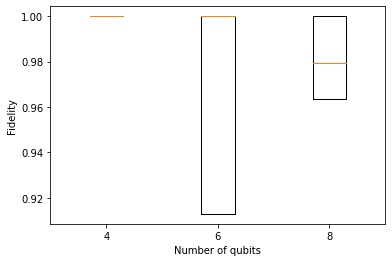

In [41]:
import matplotlib.pyplot as plt 

data = list(fidelity_dict.values())
# means = [np.mean(x) for x in data]
# std_devs = [np.std(x) for x in data]
fig,ax = plt.subplots() 
# ax.scatter(range(len(means)),means)
# ax.errorbar(range(len(means)),means, yerr = std_devs, fmt = "o")
ax.boxplot(data, whis = 0, showfliers=0, meanline = True, labels = [4,6,8])
ax.set_ylabel("Fidelity")
ax.set_xlabel("Number of qubits")
plt.savefig("FidelityAgainstNumberOfQubits.pdf")